# Diversity of Ideas: Princeton


## 1. Setup


In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')
from util.ouraws import (
    getFromFile
)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
%pwd

'c:\\Users\\theod\\OneDrive\\dev\\diversity-ideas\\notebooks\\2024'

In [4]:
df = getFromFile("../../data/princeton-opinion.parquet", False)
df.shape

(10291, 6)

In [5]:
df.head(4)

,title,url,body,year,month,day
0,The U. doesn’t want you to know about the came...,https://www.dailyprincetonian.com/article/2025...,The U. doesn’t want you to know about the came...,2025,1,1
1,Princeton should incorporate well-being days i...,https://www.dailyprincetonian.com/article/2025...,Princeton should incorporate well-being days i...,2025,1,1
2,Princeton must protect students from Trump’s p...,https://www.dailyprincetonian.com/article/2025...,Princeton must protect students from Trump’s p...,2025,1,1
3,"Princeton, why don’t you care about the workin...",https://www.dailyprincetonian.com/article/2024...,"Princeton, why don’t you care about the workin...",2024,12,1


## 2. Function Definitions


In [6]:
import numpy as np
import re

In [7]:
def getCovDispersion(wv):
    """
    Calculate various dispersion measures using the covariance matrix of word vectors.
    
    Args:
        wv: numpy array of shape (n_documents, embedding_dim) containing document embeddings
        
    Returns:
        tuple containing:
        - N: number of documents
        - trace_norm: average variance along the diagonal
        - l1_norm: L1 norm of covariance matrix (normalized)
        - l2_norm: L2 norm of covariance matrix (normalized)
        - inf_norm: Infinity norm of covariance matrix (normalized)
    """
    # Get number of documents
    N = len(wv)
    
    # Calculate covariance matrix of the word vectors
    # This measures how dimensions vary together across documents
    cov = np.cov(wv)
    
    return (
        N,  # Number of documents
        np.trace(cov)/N,  # Average variance along diagonal (spread in each dimension)
        np.linalg.norm(cov, ord=1)/N,  # L1 norm (sum of absolute values)
        np.linalg.norm(cov, ord=2)/N,  # L2/Spectral norm (largest singular value)
        np.linalg.norm(cov, ord=np.inf)/N,  # Infinity norm (max absolute row sum)
    )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [8]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [9]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [11]:
diversity_pattern = "|".join(diversity_lemmas)

Let's verify how the "count" of diversity words in the text is calculated.


In [12]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

### Cynicism related declarations


In [13]:
# Define LIWC-style categories for cynicism analysis
liwc_cynicism = {
    "skepticism": {"skeptical", "doubtful", "unconvinced", "uncertain", "wary", "dubious"},
    "mistrust": {"untrustworthy", "suspicious", "distrustful", "unreliable", "shady", "rigged", "lying"},
    "questionable": {"questionable", "dubious", "problematic", "concerning", "suspect"},
    "dishonesty": {"dishonest", "lie", "lying", "deceptive", "misleading", "false", "fake"},
    "manipulation": {"manipulative", "coercive", "exploitative", "calculated", "scheming"},
    "corruption": {"corrupt", "bribed", "compromised", "unethical", "crooked", "lying"},
    "negativity": {"bad", "worse", "worst", "terrible", "awful", "disastrous", "weird"},
    "certainty": {"obviously", "definitely", "certainly", "undoubtedly", "absolutely", "clearly"}
}

liwc_cynicism_keys = [key for key in liwc_cynicism if key != "certainty"]
liwc_cynicism_keys

['skepticism',
 'mistrust',
 'questionable',
 'dishonesty',
 'manipulation',
 'corruption',
 'negativity']

In [14]:
def liwc_analysis(text):
    """Analyze text using LIWC-style categories for cynicism."""
    tokens = [token.lower() for token in word_tokenize(text) 
              if token.isalnum()]  # Only include alphanumeric tokens
    word_counts = Counter(tokens)
    total_words = sum(word_counts.values())
    
    # Initialize scores dict with all categories
    liwc_scores = {category: 0 for category in liwc_cynicism.keys()}
    
    # Count matches for each category
    for category, words in liwc_cynicism.items():
        category_count = sum(word_counts[word] for word in words if word in word_counts)
        if total_words > 0:
            liwc_scores[category] = round(category_count / total_words, 4)
    
    # Debug print
    # print("LIWC categories found:", list(liwc_scores.keys()))
    
    return liwc_scores

In [15]:
def compute_cynicism_score(row):
    """Compute cynicism score from LIWC categories."""
    # Create a set of categories excluding 'certainty'
    cynicism_categories = set(liwc_cynicism.keys()) - {'certainty'}
    certainty_weight = 1
    
    # Debug print
    # print("Available columns:", row.index.tolist())
    # print("Looking for categories:", list(cynicism_categories))
    
    # Check if all required categories exist
    missing_categories = [cat for cat in cynicism_categories if cat not in row.index]
    if missing_categories:
        print(f"Missing categories: {missing_categories}")
        return 0.0
    
    try:
        cynicism_score = (sum(row[category] for category in cynicism_categories) - 
                         certainty_weight * row["certainty"]) / len(cynicism_categories)
        return round(cynicism_score, 4)
    except Exception as e:
        print(f"Error computing cynicism score: {e}")
        print(f"Row data: {row}")
        return 0.0

In [16]:
def cronbach_alpha(df):
    """Compute Cronbach's Alpha for internal consistency of LIWC categories."""
    # items = df[liwc_cynicism_keys]
    items = df[liwc_cynicism.keys()]
    item_vars = items.var(axis=0, ddof=1)
    total_var = items.sum(axis=1).var(ddof=1)
    n = items.shape[1]
    return (n / (n - 1)) * (1 - sum(item_vars) / total_var)

## 3. Diversity Analysis


In [17]:
from openai import OpenAI
from typing import List
import numpy as np
client = OpenAI()

In [18]:
def get_embedding(text: str) -> List[float]:
    """
    Get embeddings for a single text using text-embedding-3-large model.
    
    Args:
        text (str): The input text to generate embeddings for
        
    Returns:
        List[float]: The embedding vector
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
        dimensions=1024  # Optional: You can specify 256, 512, or 1024 dimensions
    )
    return response.data[0].embedding

def get_batch_embeddings(texts: List[str]) -> List[List[float]]:
    """
    Get embeddings for multiple texts in a single API call.
    
    Args:
        texts (List[str]): List of input texts to generate embeddings for
        
    Returns:
        List[List[float]]: List of embedding vectors
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=texts,
        dimensions=1024
    )
    return [item.embedding for item in response.data]

In [19]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    # Step 1: Clean and normalize each text in the series
    # - Convert to lowercase
    # - Lemmatize each word (convert to base form)
    # - Remove stopwords
    # - Join words back together with spaces
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    
    # Step 2: Filter out short texts
    # Remove any text less than 100 characters as they're likely too short for meaningful analysis
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    
    # Step 3: Remove any null values created by the previous step
    text_series = text_series.dropna()
    
    # Step 4: Count diversity-related terms
    # Sum up all instances of diversity-related words (defined in diversity_pattern)
    # across all remaining texts in the series
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    
    # Return both the cleaned text series and the total count of diversity words
    return text_series, total_diversity_words

In [21]:
START_YEAR = 2009
FINAL_YEAR = 2024

In [22]:
year_2024 = df[df.year==2024]
clean_df, num_diversity_words = prepText(year_2024.body)
wv = get_batch_embeddings(clean_df)

In [23]:
type(wv[0])

list

In [24]:
docmatrix = np.array(wv)

In [25]:
docmatrix.shape

(210, 1024)

In [26]:
pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
cov = getCovDispersion(docmatrix)
print(f"{year_2024.year}, {cov[0]}, {cov[1]}, {pairwise}")

3      2024
4      2024
5      2024
6      2024
7      2024
       ... 
208    2024
209    2024
210    2024
211    2024
212    2024
Name: year, Length: 210, dtype: int64, 210, 0.0009770613139068246, 0.2585358161024413


In [27]:
# VADER Sentiment Analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [28]:
def chunk_process_embeddings(clean_df):
    """
    Process embeddings in chunks and combine results.
    
    Args:
        clean_df: pandas Series of cleaned text
    
    Returns:
        List of embeddings
    """
    # Calculate chunk size (divide into 3 equal parts)
    chunk_size = len(clean_df) // 3
    
    # Split into 3 chunks
    chunks = [
        clean_df[i:i + chunk_size] 
        for i in range(0, len(clean_df), chunk_size)
    ]
    
    # Process each chunk and combine results
    all_embeddings = []
    for chunk in chunks:
        chunk_embeddings = get_batch_embeddings(chunk)
        all_embeddings.extend(chunk_embeddings)
    
    return all_embeddings

In [29]:
results = []
print(f"{'year':<12}{'size':<12}{'trace':<12}{'pairwise':<12}{'vader':<12}{'lexical':<12}{'alpha':<12}")
print("-"*78)
LIWC_SCORE_NAME = "cinicism_lexical"
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = chunk_process_embeddings(clean_df)
    
    docmatrix = np.array(wv)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    # -------------- VADER: Sentiment Analysis ----------------- #
    pos_scores = []
    neg_scores = []
    neu_scores = []
    compound_scores = []
    
    for text in clean_df:
        sentiment_scores = sia.polarity_scores(text)
        pos_scores.append(sentiment_scores['pos'])
        neg_scores.append(sentiment_scores['neg'])
        neu_scores.append(sentiment_scores['neu'])
        compound_scores.append(sentiment_scores['compound']) 
 
    # --------------- LIWC: Lexical Analysis -------------------- #
    temp_df = clean_df.copy()
    
    # Apply LIWC analysis and convert results to separate columns
    liwc_scores = temp_df.apply(liwc_analysis)

    # Convert the series of dictionaries to a DataFrame
    liwc_columns = pd.DataFrame.from_records(liwc_scores.values)
    
    # Combine with original DataFrame
    temp_df = pd.DataFrame(temp_df, columns=['text'])
    liwc_df = pd.concat([temp_df, liwc_columns], axis=1)
    alpha = cronbach_alpha(liwc_df)
    
    # Calculate cynicism score
    liwc_df[LIWC_SCORE_NAME] = liwc_df.apply(compute_cynicism_score, axis=1)
    sum_liwc_score = liwc_df[LIWC_SCORE_NAME].sum()
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0],
              'pos': sum(pos_scores) / len(pos_scores),
              'neg': sum(neg_scores) / len(neg_scores),
              'neu': sum(neu_scores) / len(neu_scores),
              'vader': sum(compound_scores) / len(compound_scores),
              'lexical': sum_liwc_score,
              'alpha': alpha
    }
    results.append(result)
    
    print(f"{year:<12}{cov[0]:<12}{cov[1]:<12.3f}{pairwise:<12.3f}{result['vader']:<12.3f}{result['lexical']:<12.3f}{result['alpha']:<12.3f}")

year        size        trace       pairwise    vader       lexical     alpha       
------------------------------------------------------------------------------
2009        445         0.001       0.318       0.786       0.250       0.188       
2010        429         0.001       0.305       0.770       0.237       0.017       
2011        422         0.001       0.322       0.759       0.236       -0.040      
2012        415         0.001       0.301       0.834       0.230       0.131       
2013        486         0.001       0.327       0.748       0.266       -0.058      
2014        487         0.001       0.420       0.523       0.240       -0.015      
2015        483         0.001       0.419       0.489       0.195       0.342       
2016        411         0.001       0.454       0.593       0.171       -0.006      
2017        496         0.001       0.401       0.574       0.076       0.050       
2018        422         0.001       0.361       0.646       0.039      

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 13380 tokens (13380 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

In [30]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm,pos,neg,neu,vader,lexical,alpha
year,,,,,,,,,,,,,,
2009,0.532354,340,0.000977,0.000554,0.000464,0.000554,92,0.270588,0.183318,0.108606,0.708074,0.609902,0.0166,0.015855
2010,0.512260,371,0.000977,0.000584,0.000485,0.000584,94,0.253369,0.179404,0.111105,0.709453,0.543613,0.0321,-0.067894
2011,0.531752,338,0.000977,0.000552,0.000465,0.000552,160,0.473373,0.180929,0.122444,0.696612,0.479181,0.0288,0.083820
2012,0.560321,359,0.000977,0.000535,0.000436,0.000535,164,0.456825,0.173240,0.113638,0.713156,0.485709,0.0347,0.133900
2013,0.529634,139,0.000977,0.000563,0.000470,0.000563,50,0.359712,0.178086,0.117302,0.704597,0.532030,0.0021,0.055486
2014,0.501158,341,0.000977,0.000581,0.000496,0.000581,200,0.586510,0.171557,0.111238,0.717185,0.461246,0.0408,0.120574
2015,0.534605,323,0.000977,0.000559,0.000464,0.000559,167,0.517028,0.170814,0.113712,0.715467,0.431733,0.0345,0.137114
2016,0.541510,274,0.000977,0.000548,0.000455,0.000548,211,0.770073,0.178828,0.111088,0.710058,0.579424,0.0370,0.200777
2017,0.567258,298,0.000977,0.000522,0.000431,0.000522,187,0.627517,0.172111,0.111003,0.716856,0.505471,0.0754,0.042566


### Regress Goodness of Fit: Pairwise Dispersion


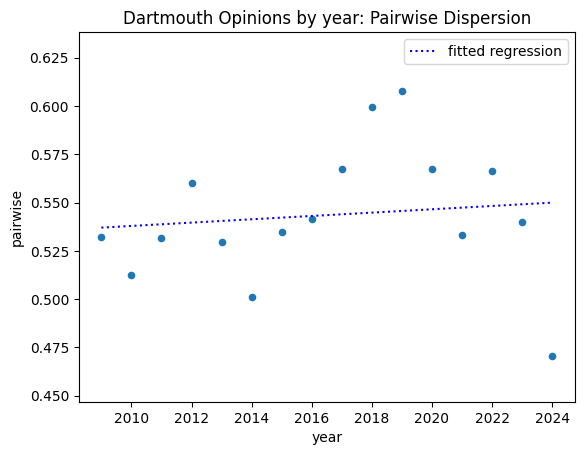

In [31]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Dartmouth Opinions by year: Pairwise Dispersion")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

### Regress Goodness of Fit: VADER Sentiment Analysis


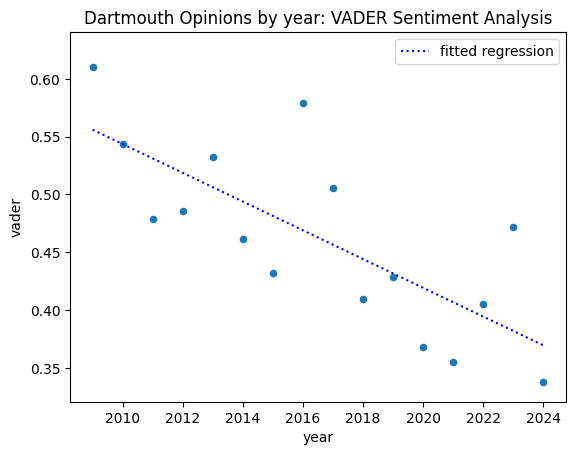

In [32]:
x = results_df['year']
y = results_df['vader']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="vader", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Dartmouth Opinions by year: VADER Sentiment Analysis")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

### Regress Goodness of Fit: LIWC Lexical Analysis


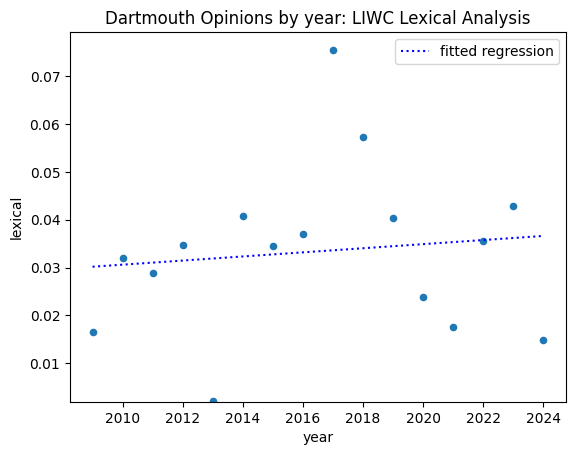

In [33]:
x = results_df['year']
y = results_df['lexical']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="lexical", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Dartmouth Opinions by year: LIWC Lexical Analysis")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

## Combined Diversity and Sentiment Analyses



mentions-norm metrics:
  slope: 0.02648
  95% CI: (0.01145, 0.04150)
  std error: 0.00701
  p-value: 0.00203
  r-value: 0.71067

pairwise metrics:
  slope: 0.00086
  95% CI: (-0.00328, 0.00500)
  std error: 0.00193
  p-value: 0.66181
  r-value: 0.11858

vader metrics:
  slope: -0.01243
  95% CI: (-0.01874, -0.00613)
  std error: 0.00294
  p-value: 0.00085
  r-value: -0.74878

lexical metrics:
  slope: 0.00043
  95% CI: (-0.00165, 0.00250)
  std error: 0.00097
  p-value: 0.66460
  r-value: 0.11755


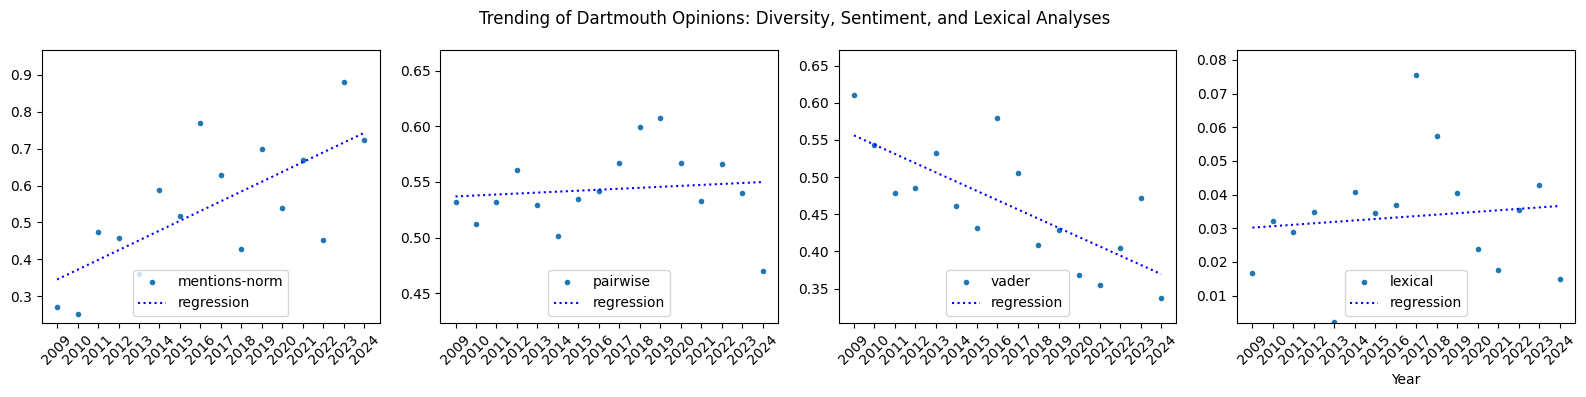

In [34]:
from scipy.stats import t

# Select the columns to plot
columns = ["mentions-norm", "pairwise", "vader", "lexical"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Calculate 95% confidence interval
    confidence_level = 0.95
    degrees_of_freedom = len(x) - 2
    t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
    margin_of_error = t_value * std_err
    ci_lower = slope - margin_of_error
    ci_upper = slope + margin_of_error
    
    # Print comprehensive statistics
    print(f"\n{column} metrics:")
    print(f"  slope: {slope:.5f}")
    print(f"  95% CI: ({ci_lower:.5f}, {ci_upper:.5f})")
    print(f"  std error: {std_err:.5f}")
    print(f"  p-value: {p_value:.5f}")
    print(f"  r-value: {r_value:.5f}")

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(min(y)*0.9, max(y)*1.1)
    # ax.set_ylim(0.0, 1.0)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    ax.tick_params(axis='x', rotation=45)
    
plt.xlabel("Year")
plt.suptitle("Trending of Dartmouth Opinions: Diversity, Sentiment, and Lexical Analyses")
plt.tight_layout()
plt.show()

In [35]:
from scipy.stats import t, linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

confidence_level = 0.95
degrees_of_freedom = len(x) - 2
t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

margin_of_error = t_value * std_err

ci_lower = slope - margin_of_error
ci_upper = slope + margin_of_error

print(f"Slope: {slope:.5f}")
print(f"95% Confidence Interval: ({ci_lower:.5f}, {ci_upper:.5f})")
print(f"Standard Error: {std_err:.5f}")
print(f"P-value: {p_value:.5f}")

Slope: 0.00086
95% Confidence Interval: (-0.00328, 0.00500)
Standard Error: 0.00193
P-value: 0.66181


## 4. VADER Sentiment Analysis

First, you need to install the VADER sentiment analysis tool. If you're using Python, you can install it with the nltk (Natural Language Toolkit) library.


In [36]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Analyze the Sentiment of Text:**

Once you have the SentimentIntensityAnalyzer instance, you can use the .polarity_scores() method to analyze the sentiment of a given text. This method returns a dictionary with the following scores:

- positive: A score for the positive sentiment.
- neutral: A score for the neutral sentiment.
- negative: A score for the negative sentiment.
- compound: The overall sentiment score, which is a normalized value between -1 (most negative) and +1 (most positive).


In [37]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    # wv = get_batch_embeddings(clean_df)

    # Calculate sentiment scores for each text and average them
    pos_scores = []
    neg_scores = []
    neu_scores = []
    compound_scores = []
    
    for text in clean_df:
        sentiment_scores = sia.polarity_scores(text)
        pos_scores.append(sentiment_scores['pos'])
        neg_scores.append(sentiment_scores['neg'])
        neu_scores.append(sentiment_scores['neu'])
        compound_scores.append(sentiment_scores['compound'])
    
    result = {'year': year,
              'pos': sum(pos_scores) / len(pos_scores),
              'neg': sum(neg_scores) / len(neg_scores),
              'neu': sum(neu_scores) / len(neu_scores),
              'compound': sum(compound_scores) / len(compound_scores)}
    
    results.append(result)

In [38]:
for result in results:
    print(f"year: {result['year']}, pos: {result['pos']:.2f}, neg: {result['neg']:.2f}, neu: {result['neu']:.2f}, compound: {result['compound']:.2f}")

year: 2009, pos: 0.18, neg: 0.11, neu: 0.71, compound: 0.61
year: 2010, pos: 0.18, neg: 0.11, neu: 0.71, compound: 0.54
year: 2011, pos: 0.18, neg: 0.12, neu: 0.70, compound: 0.48
year: 2012, pos: 0.17, neg: 0.11, neu: 0.71, compound: 0.49
year: 2013, pos: 0.18, neg: 0.12, neu: 0.70, compound: 0.53
year: 2014, pos: 0.17, neg: 0.11, neu: 0.72, compound: 0.46
year: 2015, pos: 0.17, neg: 0.11, neu: 0.72, compound: 0.43
year: 2016, pos: 0.18, neg: 0.11, neu: 0.71, compound: 0.58
year: 2017, pos: 0.17, neg: 0.11, neu: 0.72, compound: 0.51
year: 2018, pos: 0.16, neg: 0.10, neu: 0.74, compound: 0.41
year: 2019, pos: 0.16, neg: 0.11, neu: 0.73, compound: 0.43
year: 2020, pos: 0.16, neg: 0.11, neu: 0.73, compound: 0.37
year: 2021, pos: 0.14, neg: 0.10, neu: 0.76, compound: 0.36
year: 2022, pos: 0.14, neg: 0.09, neu: 0.77, compound: 0.41
year: 2023, pos: 0.15, neg: 0.09, neu: 0.76, compound: 0.47
year: 2024, pos: 0.16, neg: 0.11, neu: 0.73, compound: 0.34


Regression results:
Slope: -0.0124 (change in compound score per year)
R-squared: 0.5607
P-value: 0.0008


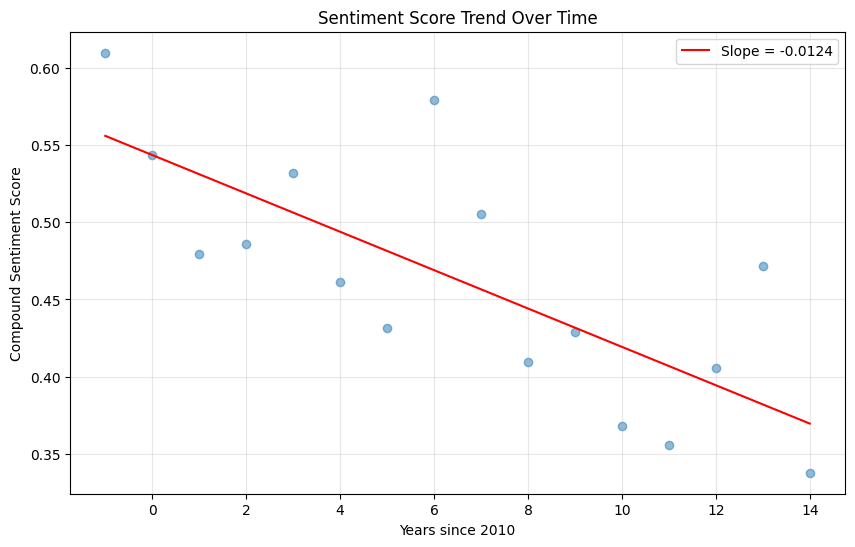

In [39]:
import numpy as np
from scipy import stats

# First convert results list to a DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# Create array of years since 2010
base_year = 2010
years_since_2010 = results_df['year'] - base_year

# Get compound scores
compound_scores = results_df['compound']

# Calculate regression
slope, intercept, r_value, p_value, std_err = stats.linregress(years_since_2010, compound_scores)

print(f"Regression results:")
print(f"Slope: {slope:.4f} (change in compound score per year)")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

# Optional: Plot the regression line
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(years_since_2010, compound_scores, alpha=0.5)
plt.plot(years_since_2010, intercept + slope * years_since_2010, 'r', 
         label=f'Slope = {slope:.4f}')
plt.xlabel('Years since 2010')
plt.ylabel('Compound Sentiment Score')
plt.title('Sentiment Score Trend Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()